# Reed Solomon Code



R 0 1 2 3 4 5 6 7 8 9 10
X_ERROR(0.1) 0 1 2 3 4 5 6
CX 0 7 1 7 2 7 3 7
M 7
DETECTOR rec[-1]
CX 1 8 2 8 3 8 4 8
M 8
DETECTOR rec[-1]
CX 2 9 3 9 4 9 5 9
M 9
DETECTOR rec[-1]
CX 3 10 4 10 5 10 6 10
M 10
DETECTOR rec[-1]


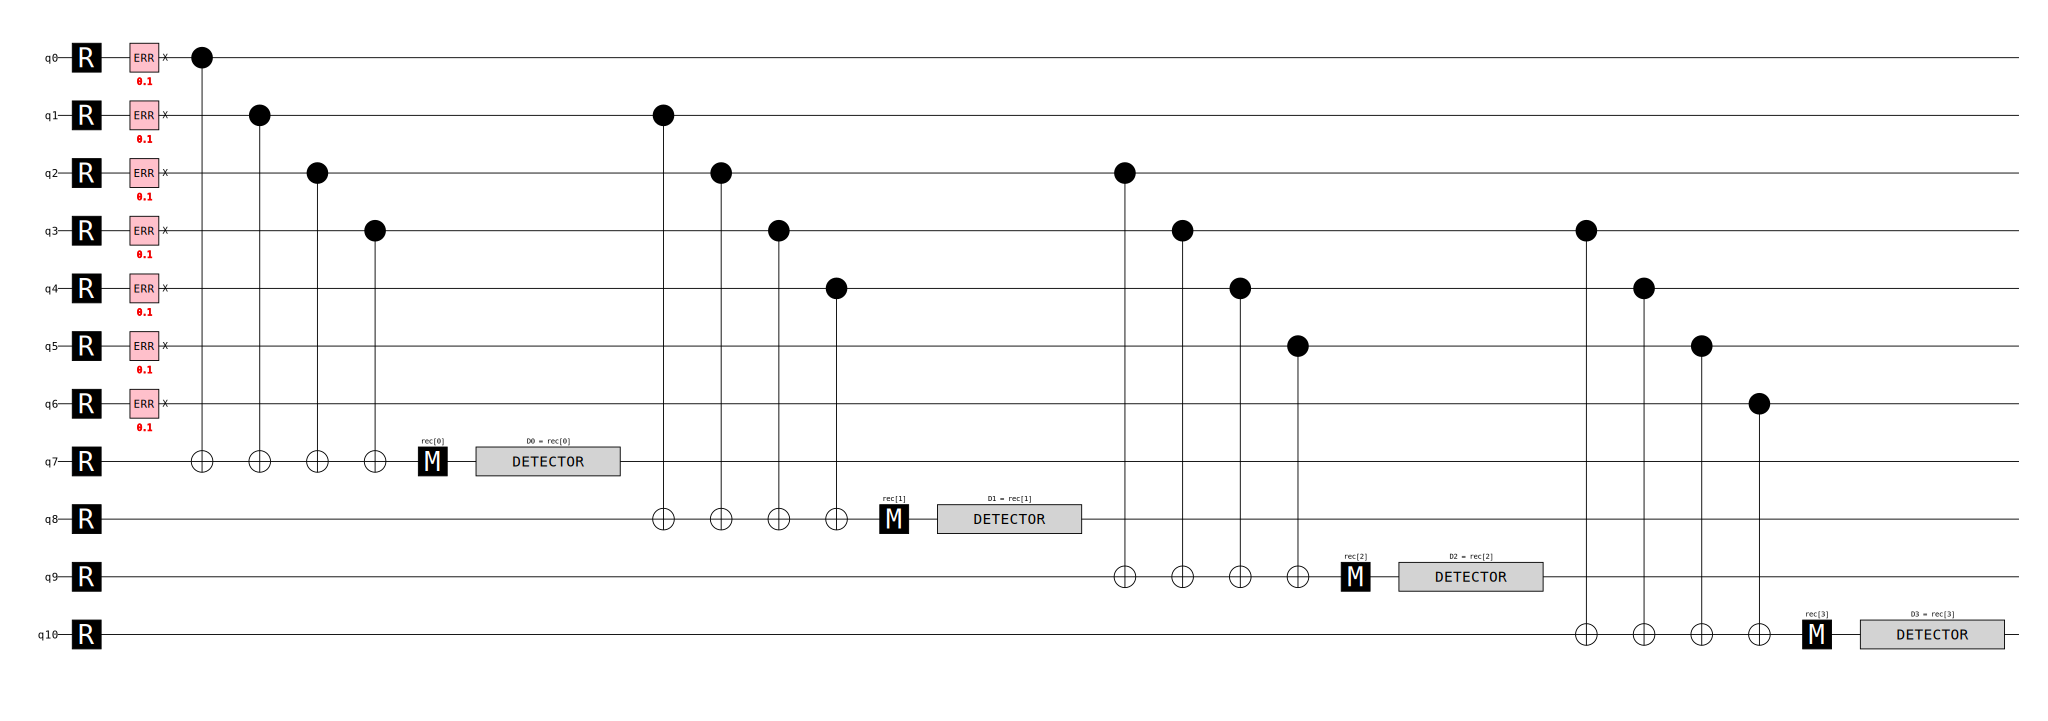

In [4]:
import stim

def rs_circuit(p=0.0):
    """
    RS[7,3,5]
    """
    c = stim.Circuit()

    data = list(range(7))
    anc  = list(range(7, 11))

    c.append("R", data + anc)

    # X noise
    if p > 0:
        c.append("X_ERROR", data, p)

    # Z stabilizers
    stabilizers = [
        [0, 1, 2, 3],  # S0
        [1, 2, 3, 4],  # S1
        [2, 3, 4, 5],  # S2
        [3, 4, 5, 6],  # S3
    ]

    # measure stabilizers 
    for s, a in zip(stabilizers, anc):
        for q in s:
            c.append("CX", [q, a])
        c.append("M", [a])

        c.append("DETECTOR", [stim.target_rec(-1)])

    return c

c = rs_circuit(p=0.1)
print(c)

c.diagram('timeline-svg')





In [5]:
from itertools import combinations

stabilizers = [
    [0, 1, 2, 3],  # S0
    [1, 2, 3, 4],  # S1
    [2, 3, 4, 5],  # S2
    [3, 4, 5, 6]   # S3
]

def compute_syndrome(error_qubits):
    """Compute 4-bit syndrome for a given set of X errors."""
    syndrome = []
    for stab in stabilizers:
        parity = sum([1 for q in error_qubits if q in stab]) % 2
        syndrome.append(parity)
    return tuple(syndrome)  # use tuple as dict key

syndrome_table = {}

# single-X errors
for q in range(7):
    synd = compute_syndrome([q])
    syndrome_table[synd] = [q]

# double-X errors
for q1, q2 in combinations(range(7), 2):
    synd = compute_syndrome([q1, q2])
    syndrome_table[synd] = [q1, q2]

def decode_syndrome(syndrome_bits):
    """
    Decode syndrome (tuple of 4 bits) to correction qubits.
    """
    syndrome = tuple(syndrome_bits)
    return syndrome_table.get(syndrome, [])

# checking
print("Single-X error syndromes:")
for q in range(7):
    print(f"Error on {q}: syndrome = {compute_syndrome([q])}")



import numpy as np

def logical_error_rate(p=0.1, num_shots=100000):
    c = rs_circuit(p)
    sampler = c.compile_sampler()

    logical_errors = 0

    for _ in range(num_shots):
        # sample measurement outcomes (single shot)
        sample = sampler.sample(shots=1)[0]

        # 1st 4 measurements are stabilizers
        syndrome_bits = sample[:4]

        # decode to get suggested X corrections (list of data-qubit indices)
        correction_qubits = decode_syndrome(syndrome_bits)

        # logical qubit = qubit 0 (logical-X operator)
        # Apply decoder corrections to see if logical is flipped
        # For demonstration, assume initial logical state |0>
        logical_flipped = 0
        if 0 in correction_qubits:
            logical_flipped ^= 1

        if logical_flipped != 0:
            logical_errors += 1

    rate = logical_errors / num_shots
    print(f"Simulated logical error rate at p={p}: {rate}")
    return rate


if __name__ == "__main__":
    logical_error_rate(p=0.1, num_shots=1000)

Single-X error syndromes:
Error on 0: syndrome = (1, 0, 0, 0)
Error on 1: syndrome = (1, 1, 0, 0)
Error on 2: syndrome = (1, 1, 1, 0)
Error on 3: syndrome = (1, 1, 1, 1)
Error on 4: syndrome = (0, 1, 1, 1)
Error on 5: syndrome = (0, 0, 1, 1)
Error on 6: syndrome = (0, 0, 0, 1)
Simulated logical error rate at p=0.1: 0.067
